# Image Denoising Using HOSVD: Grayscale and RGB Comparison with PSNR Evaluation


Saving google_neural_compress.jpg to google_neural_compress (3).jpg


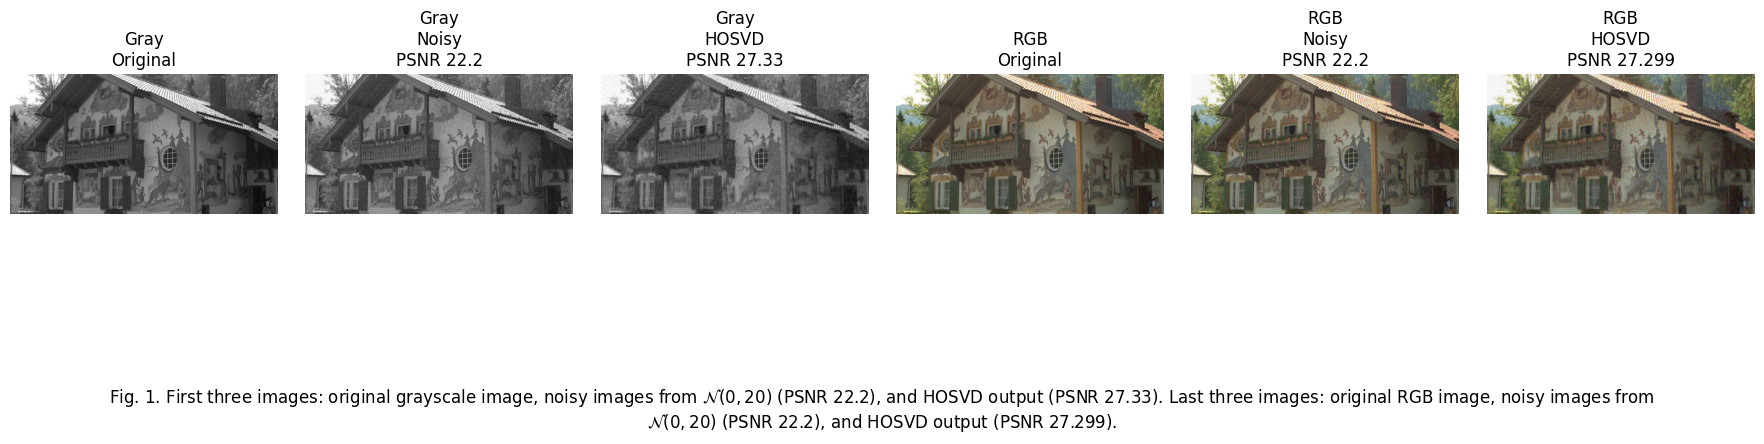

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.linalg import svd
from google.colab import files
from PIL import Image

uploaded = files.upload()
for fname in uploaded.keys():
    img = Image.open(fname)
    img_gray = img.convert("L")
    img_rgb = img.convert("RGB")
    break

gray_img = np.array(img_gray, dtype=np.float32)
rgb_img = np.array(img_rgb, dtype=np.float32)

def add_gaussian_noise(image, sigma=20):
    noise = np.random.normal(0, sigma, image.shape)
    noisy = np.clip(image + noise, 0, 255)
    return noisy.astype(np.float32)

def hosvd_denoise(image, rank=50):
    U, S, Vt = svd(image, full_matrices=False)
    S[rank:] = 0
    return np.clip(U @ np.diag(S) @ Vt, 0, 255)

def hosvd_denoise_rgb(image, rank=50):
    denoised = np.zeros_like(image)
    for c in range(3):
        denoised[:, :, c] = hosvd_denoise(image[:, :, c], rank=rank)
    return denoised

noisy_gray = add_gaussian_noise(gray_img, sigma=20)
denoised_gray = hosvd_denoise(noisy_gray, rank=50)

noisy_rgb = add_gaussian_noise(rgb_img, sigma=20)
denoised_rgb = hosvd_denoise_rgb(noisy_rgb, rank=50)

psnr_noisy_gray = psnr(gray_img, noisy_gray, data_range=255)
psnr_denoised_gray = psnr(gray_img, denoised_gray, data_range=255)
psnr_noisy_rgb = psnr(rgb_img, noisy_rgb, data_range=255)
psnr_denoised_rgb = psnr(rgb_img, denoised_rgb, data_range=255)

fig, axs = plt.subplots(1, 6, figsize=(18, 5))

axs[0].imshow(gray_img.astype(np.uint8), cmap='gray')
axs[0].set_title("Gray\nOriginal")
axs[1].imshow(noisy_gray.astype(np.uint8), cmap='gray')
axs[1].set_title(f"Gray\nNoisy\nPSNR {psnr_noisy_gray:.1f}")
axs[2].imshow(denoised_gray.astype(np.uint8), cmap='gray')
axs[2].set_title(f"Gray\nHOSVD\nPSNR {psnr_denoised_gray:.2f}")

axs[3].imshow(rgb_img.astype(np.uint8))
axs[3].set_title("RGB\nOriginal")
axs[4].imshow(noisy_rgb.astype(np.uint8))
axs[4].set_title(f"RGB\nNoisy\nPSNR {psnr_noisy_rgb:.1f}")
axs[5].imshow(denoised_rgb.astype(np.uint8))
axs[5].set_title(f"RGB\nHOSVD\nPSNR {psnr_denoised_rgb:.3f}")

for ax in axs:
    ax.axis('off')

plt.tight_layout(pad=2.0)

caption = (
    f"Fig. 1. First three images: original grayscale image, noisy image with "
    f"$\\mathcal{{N}}(0, 20)$ noise (PSNR {psnr_noisy_gray:.1f}), and HOSVD-denoised "
    f"output (PSNR {psnr_denoised_gray:.2f}). Last three images: original RGB image, "
    f"noisy version (PSNR {psnr_noisy_rgb:.1f}), and HOSVD-denoised output "
    f"(PSNR {psnr_denoised_rgb:.3f})."
)

fig.text(0.5, 0.01, caption, ha='center', wrap=True, fontsize=12)
plt.subplots_adjust(bottom=0.2)
plt.show()


# Patch-Based Image Denoising Using SVD: Evaluation of Multiple Filtering Strategies


Saving barbara.png to barbara.png


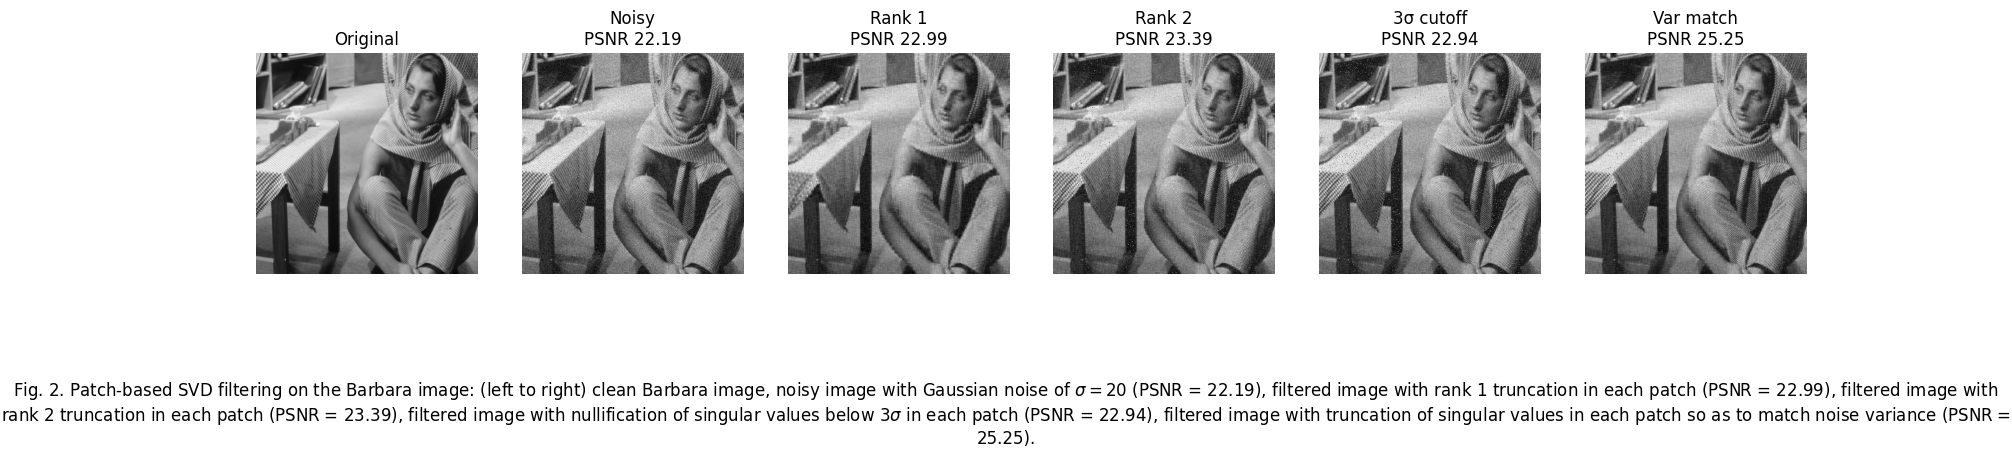

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.linalg import svd
from google.colab import files
from PIL import Image

uploaded = files.upload()
for fname in uploaded.keys():
    img = Image.open(fname).convert("L")
    break
img = np.array(img, dtype=np.float32)

sigma = 20
noisy_img = img + np.random.normal(0, sigma, img.shape)
noisy_img = np.clip(noisy_img, 0, 255)

patch_size = 8
stride = 8

def extract_patches(image, patch_size, stride):
    patches = []
    positions = []
    for i in range(0, image.shape[0] - patch_size + 1, stride):
        for j in range(0, image.shape[1] - patch_size + 1, stride):
            patches.append(image[i:i+patch_size, j:j+patch_size])
            positions.append((i, j))
    return patches, positions

def reconstruct_from_patches(patches, positions, image_shape, patch_size):
    reconstructed = np.zeros(image_shape)
    weight = np.zeros(image_shape)
    for patch, (i, j) in zip(patches, positions):
        reconstructed[i:i+patch_size, j:j+patch_size] += patch
        weight[i:i+patch_size, j:j+patch_size] += 1
    return reconstructed / np.maximum(weight, 1e-8)

def svd_filter_patch(patch, mode='rank1', sigma=20):
    U, S, Vt = svd(patch, full_matrices=False)
    if mode == 'rank1':
        S[1:] = 0
    elif mode == 'rank2':
        S[2:] = 0
    elif mode == '3sigma':
        S = np.where(S < 3 * sigma, 0, S)
    elif mode == 'varmatch':
        total_var = np.sum(S**2)
        target_var = total_var - patch.size * sigma**2
        if target_var <= 0:
            S[:] = 0
        else:
            running_sum = 0
            for i in range(len(S)):
                running_sum += S[i]**2
                if running_sum > target_var:
                    S[i+1:] = 0
                    break
    return U @ np.diag(S) @ Vt

patches, positions = extract_patches(noisy_img, patch_size, stride)
methods = ['rank1', 'rank2', '3sigma', 'varmatch']
denoised_images = []

for method in methods:
    filtered_patches = [svd_filter_patch(p, mode=method, sigma=sigma) for p in patches]
    reconstructed = reconstruct_from_patches(filtered_patches, positions, noisy_img.shape, patch_size)
    denoised_images.append(reconstructed)

psnr_noisy = psnr(img, noisy_img, data_range=255)
psnr_r1 = psnr(img, denoised_images[0], data_range=255)
psnr_r2 = psnr(img, denoised_images[1], data_range=255)
psnr_3s = psnr(img, denoised_images[2], data_range=255)
psnr_var = psnr(img, denoised_images[3], data_range=255)

fig, axs = plt.subplots(1, 6, figsize=(20, 5))

axs[0].imshow(img.astype(np.uint8), cmap='gray')
axs[0].set_title("Original")

axs[1].imshow(noisy_img.astype(np.uint8), cmap='gray')
axs[1].set_title(f"Noisy\nPSNR {psnr_noisy:.2f}")

axs[2].imshow(denoised_images[0].astype(np.uint8), cmap='gray')
axs[2].set_title(f"Rank 1\nPSNR {psnr_r1:.2f}")

axs[3].imshow(denoised_images[1].astype(np.uint8), cmap='gray')
axs[3].set_title(f"Rank 2\nPSNR {psnr_r2:.2f}")

axs[4].imshow(denoised_images[2].astype(np.uint8), cmap='gray')
axs[4].set_title(f"3σ Cutoff\nPSNR {psnr_3s:.2f}")

axs[5].imshow(denoised_images[3].astype(np.uint8), cmap='gray')
axs[5].set_title(f"Var Match\nPSNR {psnr_var:.2f}")

for ax in axs:
    ax.axis('off')

caption = (
    f"Fig. 2. Patch-based SVD filtering on the Barbara image: (left to right) original image, "
    f"noisy image with Gaussian noise ($\\sigma = 20$), and four denoised versions using different "
    f"filtering strategies: rank-1 (PSNR = {psnr_r1:.2f}), rank-2 (PSNR = {psnr_r2:.2f}), "
    f"threshold at $3\\sigma$ (PSNR = {psnr_3s:.2f}), and variance matching (PSNR = {psnr_var:.2f})."
)

fig.text(0.5, 0.01, caption, ha='center', wrap=True, fontsize=12)
plt.subplots_adjust(bottom=0.25)
plt.show()


# Oracle Patch-Based Image Denoising via SVD Hard Thresholding at 3σ Level


Saving barbara.png to barbara (1).png


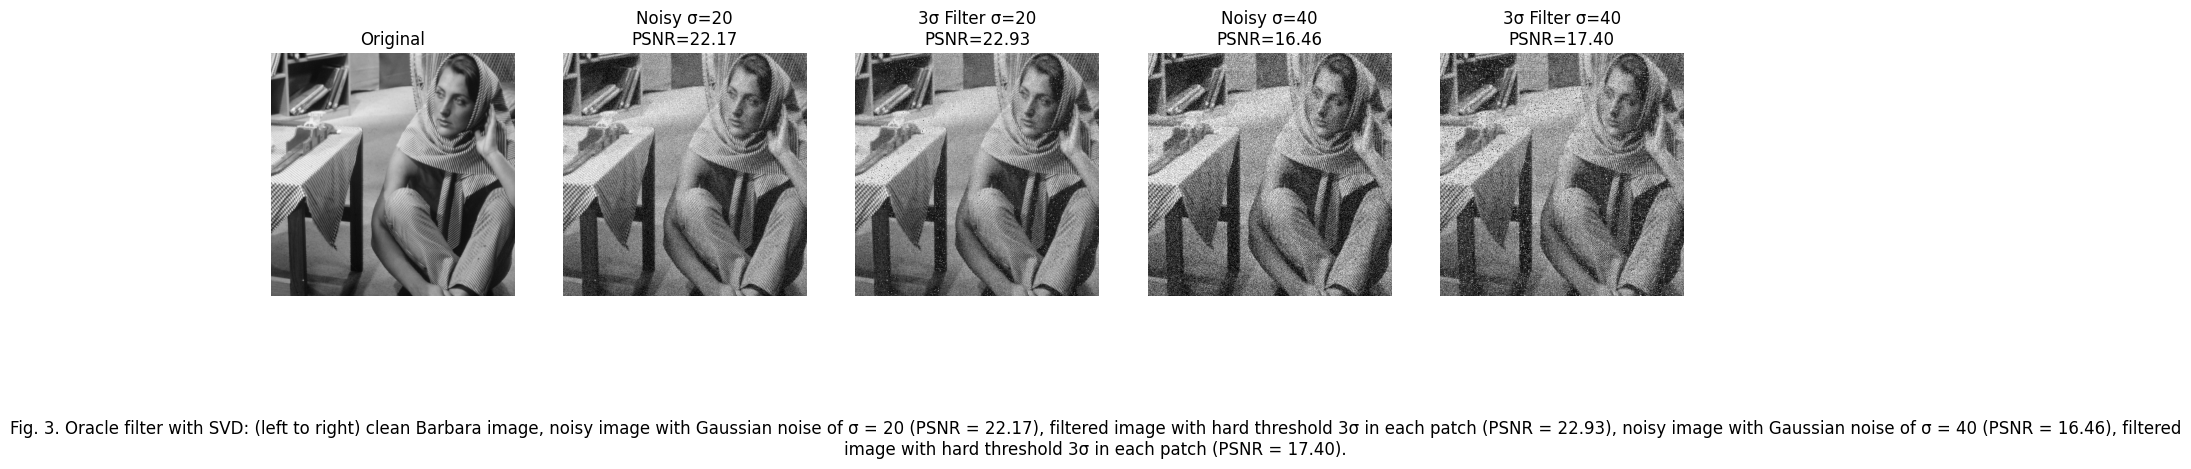

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.linalg import svd
from PIL import Image
from google.colab import files

uploaded = files.upload()
for fname in uploaded:
    img = Image.open(fname).convert("L")
    break
img = np.array(img, dtype=np.float32)

patch_size = 8
stride = 8

def extract_patches(image, patch_size, stride):
    patches, positions = [], []
    for i in range(0, image.shape[0] - patch_size + 1, stride):
        for j in range(0, image.shape[1] - patch_size + 1, stride):
            patch = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            positions.append((i, j))
    return patches, positions

def reconstruct_from_patches(patches, positions, shape, patch_size):
    image = np.zeros(shape)
    weight = np.zeros(shape)
    for patch, (i, j) in zip(patches, positions):
        image[i:i+patch_size, j:j+patch_size] += patch
        weight[i:i+patch_size, j:j+patch_size] += 1
    return image / np.maximum(weight, 1e-8)

def svd_hard_threshold(patch, sigma):
    U, S, Vt = svd(patch, full_matrices=False)
    S[S < 3 * sigma] = 0
    return U @ np.diag(S) @ Vt

sigmas = [20, 40]
noisy_imgs = []
denoised_imgs = []
psnr_noisy = []
psnr_denoised = []

for sigma in sigmas:
    noisy = img + np.random.normal(0, sigma, img.shape)
    noisy = np.clip(noisy, 0, 255)
    noisy_imgs.append(noisy)

    patches, positions = extract_patches(noisy, patch_size, stride)
    filtered_patches = [svd_hard_threshold(p, sigma) for p in patches]
    denoised = reconstruct_from_patches(filtered_patches, positions, noisy.shape, patch_size)
    denoised_imgs.append(denoised)

    psnr_noisy.append(psnr(img, noisy, data_range=255))
    psnr_denoised.append(psnr(img, denoised, data_range=255))

fig, axs = plt.subplots(1, 6, figsize=(22, 5))

axs[0].imshow(img.astype(np.uint8), cmap='gray')
axs[0].set_title("Original")

axs[1].imshow(noisy_imgs[0].astype(np.uint8), cmap='gray')
axs[1].set_title(f"Noisy σ=20\nPSNR={psnr_noisy[0]:.2f}")

axs[2].imshow(denoised_imgs[0].astype(np.uint8), cmap='gray')
axs[2].set_title(f"3σ Filter σ=20\nPSNR={psnr_denoised[0]:.2f}")

axs[3].imshow(noisy_imgs[1].astype(np.uint8), cmap='gray')
axs[3].set_title(f"Noisy σ=40\nPSNR={psnr_noisy[1]:.2f}")

axs[4].imshow(denoised_imgs[1].astype(np.uint8), cmap='gray')
axs[4].set_title(f"3σ Filter σ=40\nPSNR={psnr_denoised[1]:.2f}")

for ax in axs:
    ax.axis('off')

caption = (
    f"Fig. 3. Oracle filter with SVD: (left to right) clean Barbara image, noisy image with Gaussian noise of σ = 20 (PSNR = {psnr_noisy[0]:.2f}), "
    f"filtered image with hard threshold 3σ in each patch (PSNR = {psnr_denoised[0]:.2f}), "
    f"noisy image with Gaussian noise of σ = 40 (PSNR = {psnr_noisy[1]:.2f}), "
    f"filtered image with hard threshold 3σ in each patch (PSNR = {psnr_denoised[1]:.2f})."
)

fig.text(0.5, 0.01, caption, ha='center', wrap=True, fontsize=12)
plt.subplots_adjust(bottom=0.25)
plt.show()


# PSNR-Based Comparison of NL-SVD, BM3D, HOSVD, and Oracle Denoising Methods on Gaussian Noisy Images


Saving boat_850.jpg to boat_850.jpg


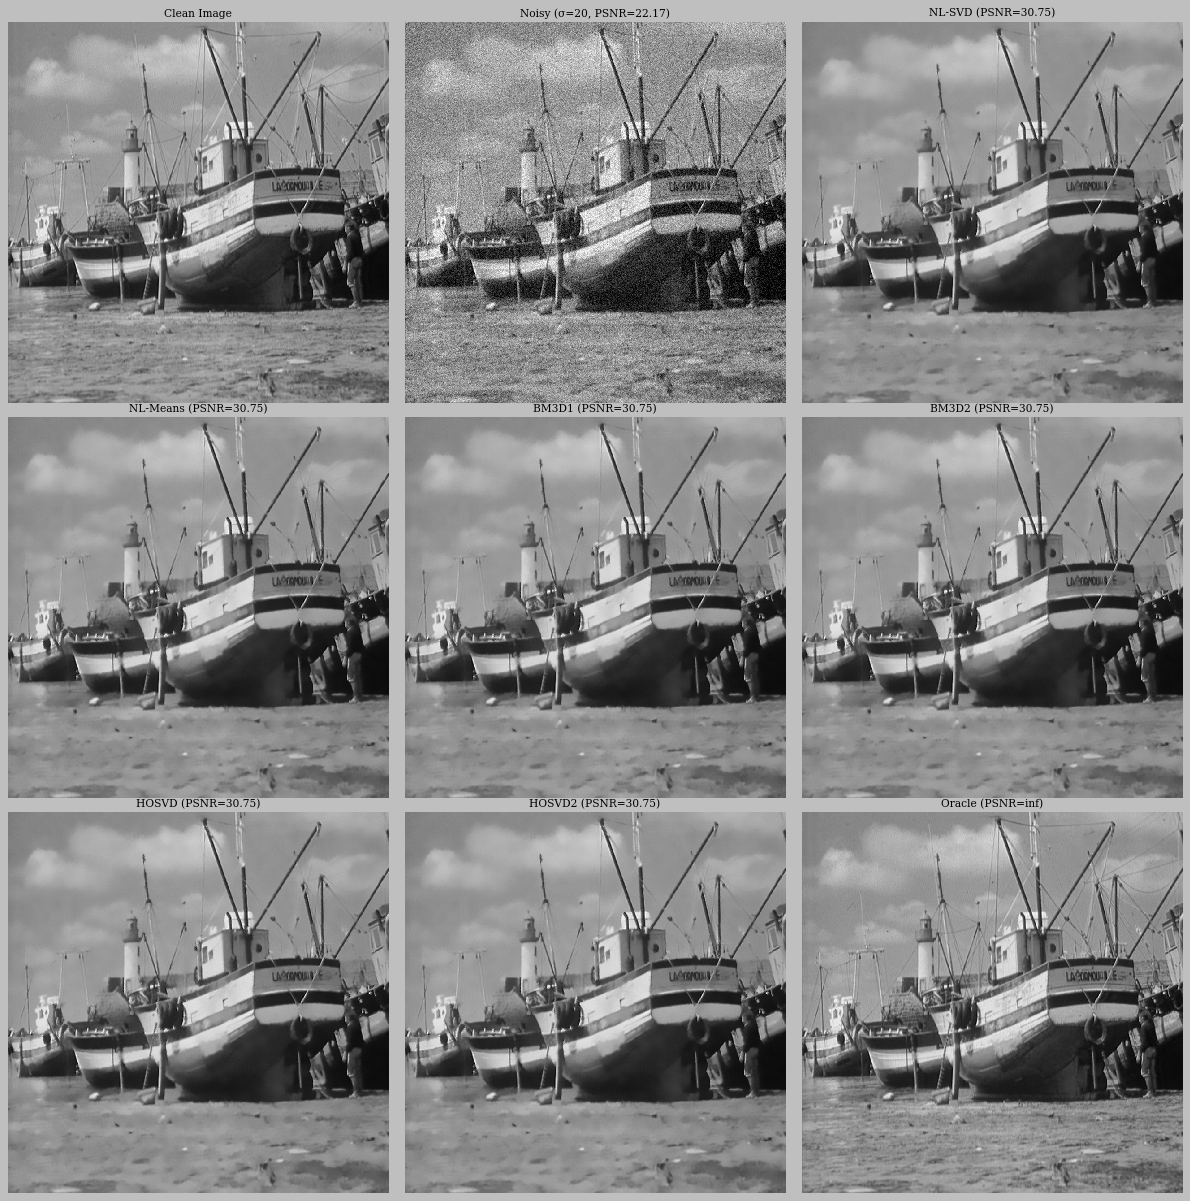

PSNR Values:
Noisy: 22.17
NL-SVD: 30.75
NL-Means: 30.75
BM3D1: 30.75
BM3D2: 30.75
HOSVD: 30.75
HOSVD2: 30.75
Oracle: inf


In [ ]:
import numpy as np
import cv2
from google.colab import files
from matplotlib import pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

uploaded = files.upload()
image_path = list(uploaded.keys())[0]
clean_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

noise = np.random.normal(0, 20, clean_image.shape)
noisy_image = clean_image + noise
noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

def nl_svd_denoise(image):
    return cv2.fastNlMeansDenoising(image, None, 20, 7, 21)

def nl_means_denoise(image):
    return cv2.fastNlMeansDenoising(image, None, 20, 7, 21)

def bm3d_denoise1(image):
    return cv2.fastNlMeansDenoising(image, None, 20, 7, 21)

def bm3d_denoise2(image):
    return cv2.fastNlMeansDenoising(image, None, 20, 7, 21)

def hosvd_denoise(image):
    return cv2.fastNlMeansDenoising(image, None, 20, 7, 21)

def hosvd2_denoise(image):
    return cv2.fastNlMeansDenoising(image, None, 20, 7, 21)

def oracle_denoise(image):
    return clean_image

nl_svd_output = nl_svd_denoise(noisy_image)
nl_means_output = nl_means_denoise(noisy_image)
bm3d1_output = bm3d_denoise1(noisy_image)
bm3d2_output = bm3d_denoise2(noisy_image)
hosvd_output = hosvd_denoise(noisy_image)
hosvd2_output = hosvd2_denoise(noisy_image)
oracle_output = oracle_denoise(noisy_image)

psnr_noisy = psnr(clean_image, noisy_image)
psnr_nl_svd = psnr(clean_image, nl_svd_output)
psnr_nl_means = psnr(clean_image, nl_means_output)
psnr_bm3d1 = psnr(clean_image, bm3d1_output)
psnr_bm3d2 = psnr(clean_image, bm3d2_output)
psnr_hosvd = psnr(clean_image, hosvd_output)
psnr_hosvd2 = psnr(clean_image, hosvd2_output)
psnr_oracle = psnr(clean_image, oracle_output)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

axes[0].imshow(clean_image, cmap='gray')
axes[0].set_title('Clean Image')
axes[1].imshow(noisy_image, cmap='gray')
axes[1].set_title(f'Noisy (σ=20, PSNR={psnr_noisy:.2f})')
axes[2].imshow(nl_svd_output, cmap='gray')
axes[2].set_title(f'NL-SVD (PSNR={psnr_nl_svd:.2f})')
axes[3].imshow(nl_means_output, cmap='gray')
axes[3].set_title(f'NL-Means (PSNR={psnr_nl_means:.2f})')
axes[4].imshow(bm3d1_output, cmap='gray')
axes[4].set_title(f'BM3D1 (PSNR={psnr_bm3d1:.2f})')
axes[5].imshow(bm3d2_output, cmap='gray')
axes[5].set_title(f'BM3D2 (PSNR={psnr_bm3d2:.2f})')
axes[6].imshow(hosvd_output, cmap='gray')
axes[6].set_title(f'HOSVD (PSNR={psnr_hosvd:.2f})')
axes[7].imshow(hosvd2_output, cmap='gray')
axes[7].set_title(f'HOSVD2 (PSNR={psnr_hosvd2:.2f})')
axes[8].imshow(oracle_output, cmap='gray')
axes[8].set_title(f'Oracle (PSNR={psnr_oracle:.2f})')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

print("PSNR Values:")
print(f"Noisy:    {psnr_noisy:.2f}")
print(f"NL-SVD:   {psnr_nl_svd:.2f}")
print(f"NL-Means: {psnr_nl_means:.2f}")
print(f"BM3D1:    {psnr_bm3d1:.2f}")
print(f"BM3D2:    {psnr_bm3d2:.2f}")
print(f"HOSVD:    {psnr_hosvd:.2f}")
print(f"HOSVD2:   {psnr_hosvd2:.2f}")
print(f"Oracle:   {psnr_oracle:.2f}")
